## Imports

In [49]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
open_shot = pd.read_csv('data/clean/open_shot.csv')
open_shot.head()

,game_id,matchup,location,win,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_id,close_def_dist,fgm,pts,player_name,player_id,defender_wingspan,close_def_dist_in,open_shot
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,81.50,15.6,0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,82.76,73.2,1
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,82.76,10.8,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,80.75,40.8,1
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,83.50,13.2,0


In [35]:
open_shot['open_shot'].value_counts()

open_shot
1    68986
0    59083
Name: count, dtype: int64

In [5]:
player_info = pd.read_csv('data/clean/player_info.csv')
player_info.head()

,nba_id,position,first,last,height,weight,draft_year,pos1,pos2,wingspan,standing_reach
0,101187,Forward-Guard,Alan,Anderson,78.0,220.0,NaN,F,G,81.50,104.0
1,202711,Forward,Bojan,Bogdanovic,79.0,226.0,2011.0,F,NaN,82.76,NaN
2,203900,Guard,Markel,Brown,75.0,190.0,2014.0,G,NaN,80.75,100.0
3,201152,Forward,Thaddeus,Young,80.0,225.0,2007.0,F,NaN,83.50,106.0
4,101114,Guard,Deron,Williams,75.0,200.0,2005.0,G,NaN,78.25,98.0


In [7]:
player_size = pd.read_csv('data/clean/player_size.csv')
player_size.head()

,first,last,draft_year,pos1,pos2,height,weight,wingspan,standing_reach
0,Ochai,Agbaji,2022,G,NaN,76.0,217.0,82.25,104.0
1,Patrick,Baldwin Jr.,2022,F,NaN,81.0,231.0,85.75,110.5
2,Dominick,Barlow,2022,F,NaN,81.0,221.0,87.00,108.5
3,MarJon,Beauchamp,2022,G,NaN,77.0,197.0,84.75,106.0
4,Hugo,Besson,2022,G,NaN,76.0,180.0,77.50,102.0


## EDA

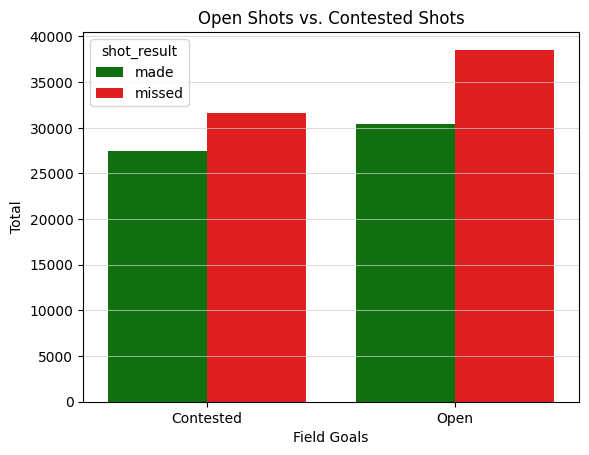

In [44]:
sns.countplot(x="open_shot", hue="shot_result", data=open_shot, palette=['green', 'red'])
plt.title('Open Shots vs. Contested Shots')
plt.xticks([0,1],['Contested','Open'])
plt.xlabel('Field Goals')
plt.ylabel('Total')
# plt.legend(['Missed','Made'])
plt.show()

The above graph analyzes the number of contested and open shots that were made and missed. We can see that there were more shots that were considered to be "open" meaning the distance of the defender to the shooter was greater than or equal to the wingspan of the defender divided by 2. We see more shots that are made when the shooter is open but we also see more shots missed.

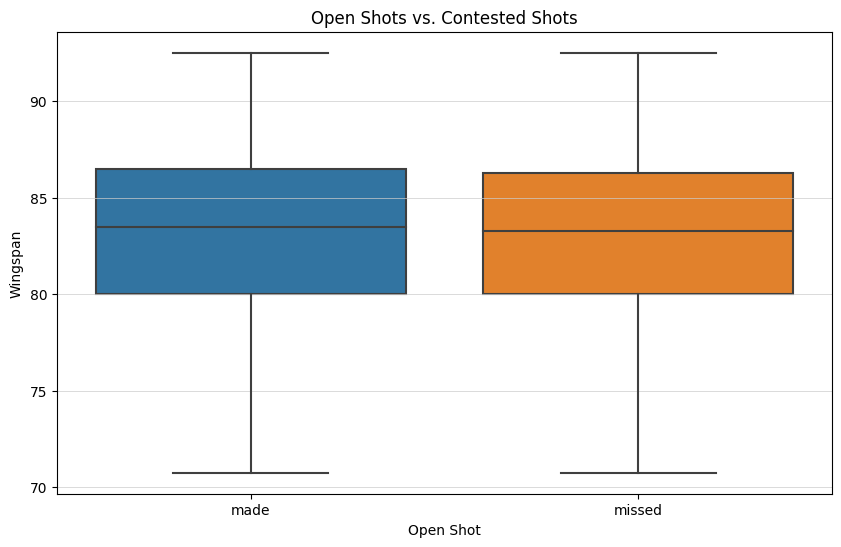

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(x='shot_result', y='defender_wingspan', data=open_shot)
plt.title('Open Shots vs. Contested Shots')
# plt.xticks([0,1],['Contested','Open'])
plt.xlabel('Open Shot')
plt.ylabel('Wingspan')
plt.show()

The wingspan of the defender does not have much impact on whether the shot goes in or not.

In [50]:
smf.ols('defender_wingspan ~ shot_result', data=open_shot).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      defender_wingspan   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     34.38
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           4.54e-09
Time:                        23:14:52   Log-Likelihood:            -3.6029e+05
No. Observations:              127495   AIC:                         7.206e+05
Df Residuals:                  127493   BIC:                         7.206e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                83.0948      0.017   4887.325      0.000      83.062      83.128
shot_result[T.missed]    -0.1347      0.023     -5.864      0.000      -0.180      -0.090
==============================================================================
Omnibus:                     4832.297   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3827.074
Skew:                          -0.342   Prob(JB):                         0.00
Kurtosis:                       2.497   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

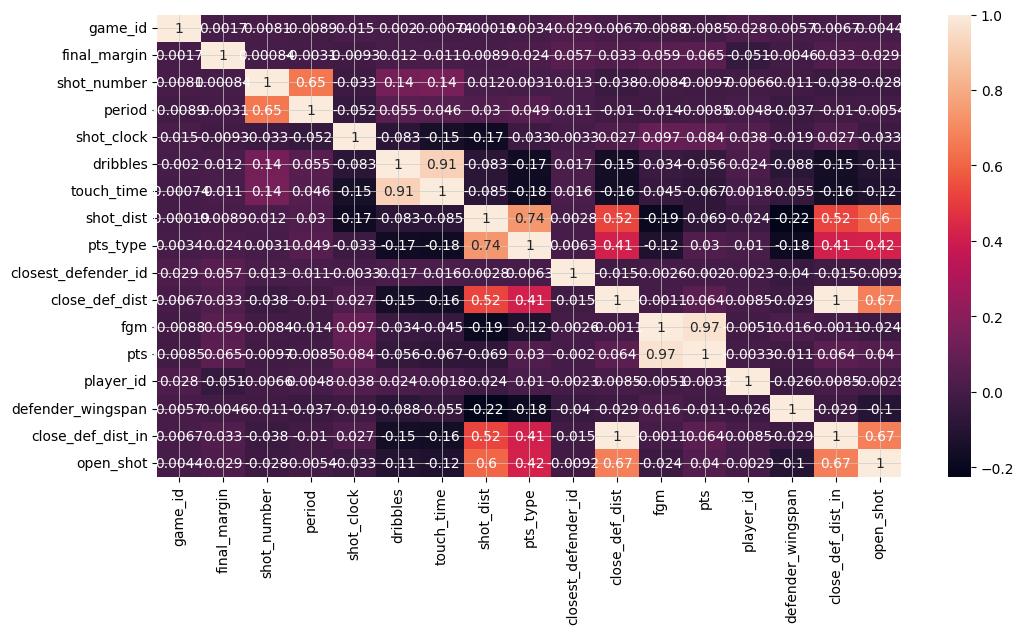

In [54]:
corr_matrix = open_shot.drop(
    columns=open_shot.select_dtypes(
        include=['object']).columns
    ).corr()

plt.figure(figsize=(12,6))
sns.heatmap(data=corr_matrix, annot=True)
plt.show()


In [56]:
t = corr_matrix
t = t.stack().reset_index()
t.columns = ['var1','var2','corr']
t = t[t['var1'] != t['var2']]
t = t.sort_values('corr', ascending=False, key=abs)
t = t.reset_index(drop=True)
t = t.iloc[::2]
t.head()


,var1,var2,corr
0,close_def_dist,close_def_dist_in,1.000000
2,pts,fgm,0.970686
4,touch_time,dribbles,0.914311
6,shot_dist,pts_type,0.740933
8,close_def_dist,open_shot,0.674653


For our purposes we can see that the distance of the closest defender is very strongly correlated with the open_shot value.